In [1]:
filename = "20200228_mouse_liver_13C_nontumor6 Analyte 3SRD19.txt"
nrows = 60
ncols = 120
#formula = "C16H32O2"
#formula = "C18H36O2"
formula = "C14H28O2"

polarity = -1
ppmThresh = 20
convSquare = 3
colormap = "gray"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import scipy.stats as stats
import skimage.filters
from helper import *
import molmass
from PIL import Image

In [4]:
func = getISAEq(formula)
f = molmass.Formula(formula)
m0Mz = f.isotope.mass
adductChange = polarity * 1.0077276
comp = f.composition()
for row in comp:
    if row[0] == "C":
        numCarbons = int(row[1])

#load in data and organize
data = [r.strip().split() for r in open(filename,"r").readlines()[3:]]
data = {(x[0],float(x[1]),float(x[2])):{mz:float(i) for mz,i in zip(data[0],x[3:])} for x in data[1:] if len(x) > 0}
data = pd.DataFrame.from_dict(data,orient="index")
cols = data.columns.values
mzs = cols


#get mzs of interest
mzsOI = [m0Mz+adductChange+1.00336*x for x in range(numCarbons+1)]
mzMatchDict = {i:{"true":m,"observed":[],"matched":False} for m,i in zip(mzsOI,range(len(mzsOI)))}

#find matching peaks in data and output found and missing peaks
for m,i in zip(mzsOI,range(len(mzsOI))):
    matched = False
    for m2 in mzs:
        tmpM2 = float(m2)
        if abs(m-tmpM2) / m * 1e6 < ppmThresh:
            mzMatchDict[i]["observed"].append(m2)
            mzMatchDict[i]["matched"] = True
            matched = True
            break
    if not matched:
        print("missed",m)
    else:
        print("found",m,mzMatchDict[i]["observed"])


found 227.20120254158 ['227.2002']
found 228.20456254157997 ['228.2032']
missed 229.20792254158
found 230.21128254157998 ['230.2071']
found 231.21464254158 ['231.2130']
found 232.21800254157998 ['232.2166']
found 233.22136254158 ['233.2205']
found 234.22472254157998 ['234.2237']
found 235.22808254158 ['235.2269']
found 236.23144254157998 ['236.2302']
found 237.23480254158 ['237.2333']
found 238.23816254157998 ['238.2366']
found 239.24152254158 ['239.2402']
missed 240.24488254157998
missed 241.24824254158


In [5]:
#gather images for mzs of interest 
tensor = []
for mz in range(numCarbons+1):
    #iterate through mzs of interest
    if mzMatchDict[mz]["matched"]:   
        outarray = np.sum(np.array([getImage(data,x,nrows,ncols) for x in mzMatchDict[mz]["observed"]]),axis=0)
        nrows = len(outarray)
        ncols = len(outarray[0])
    else:
        outarray = np.zeros((nrows,ncols))
    tensor.append(outarray)

tensor = np.array(tensor)

image can only be downsampled


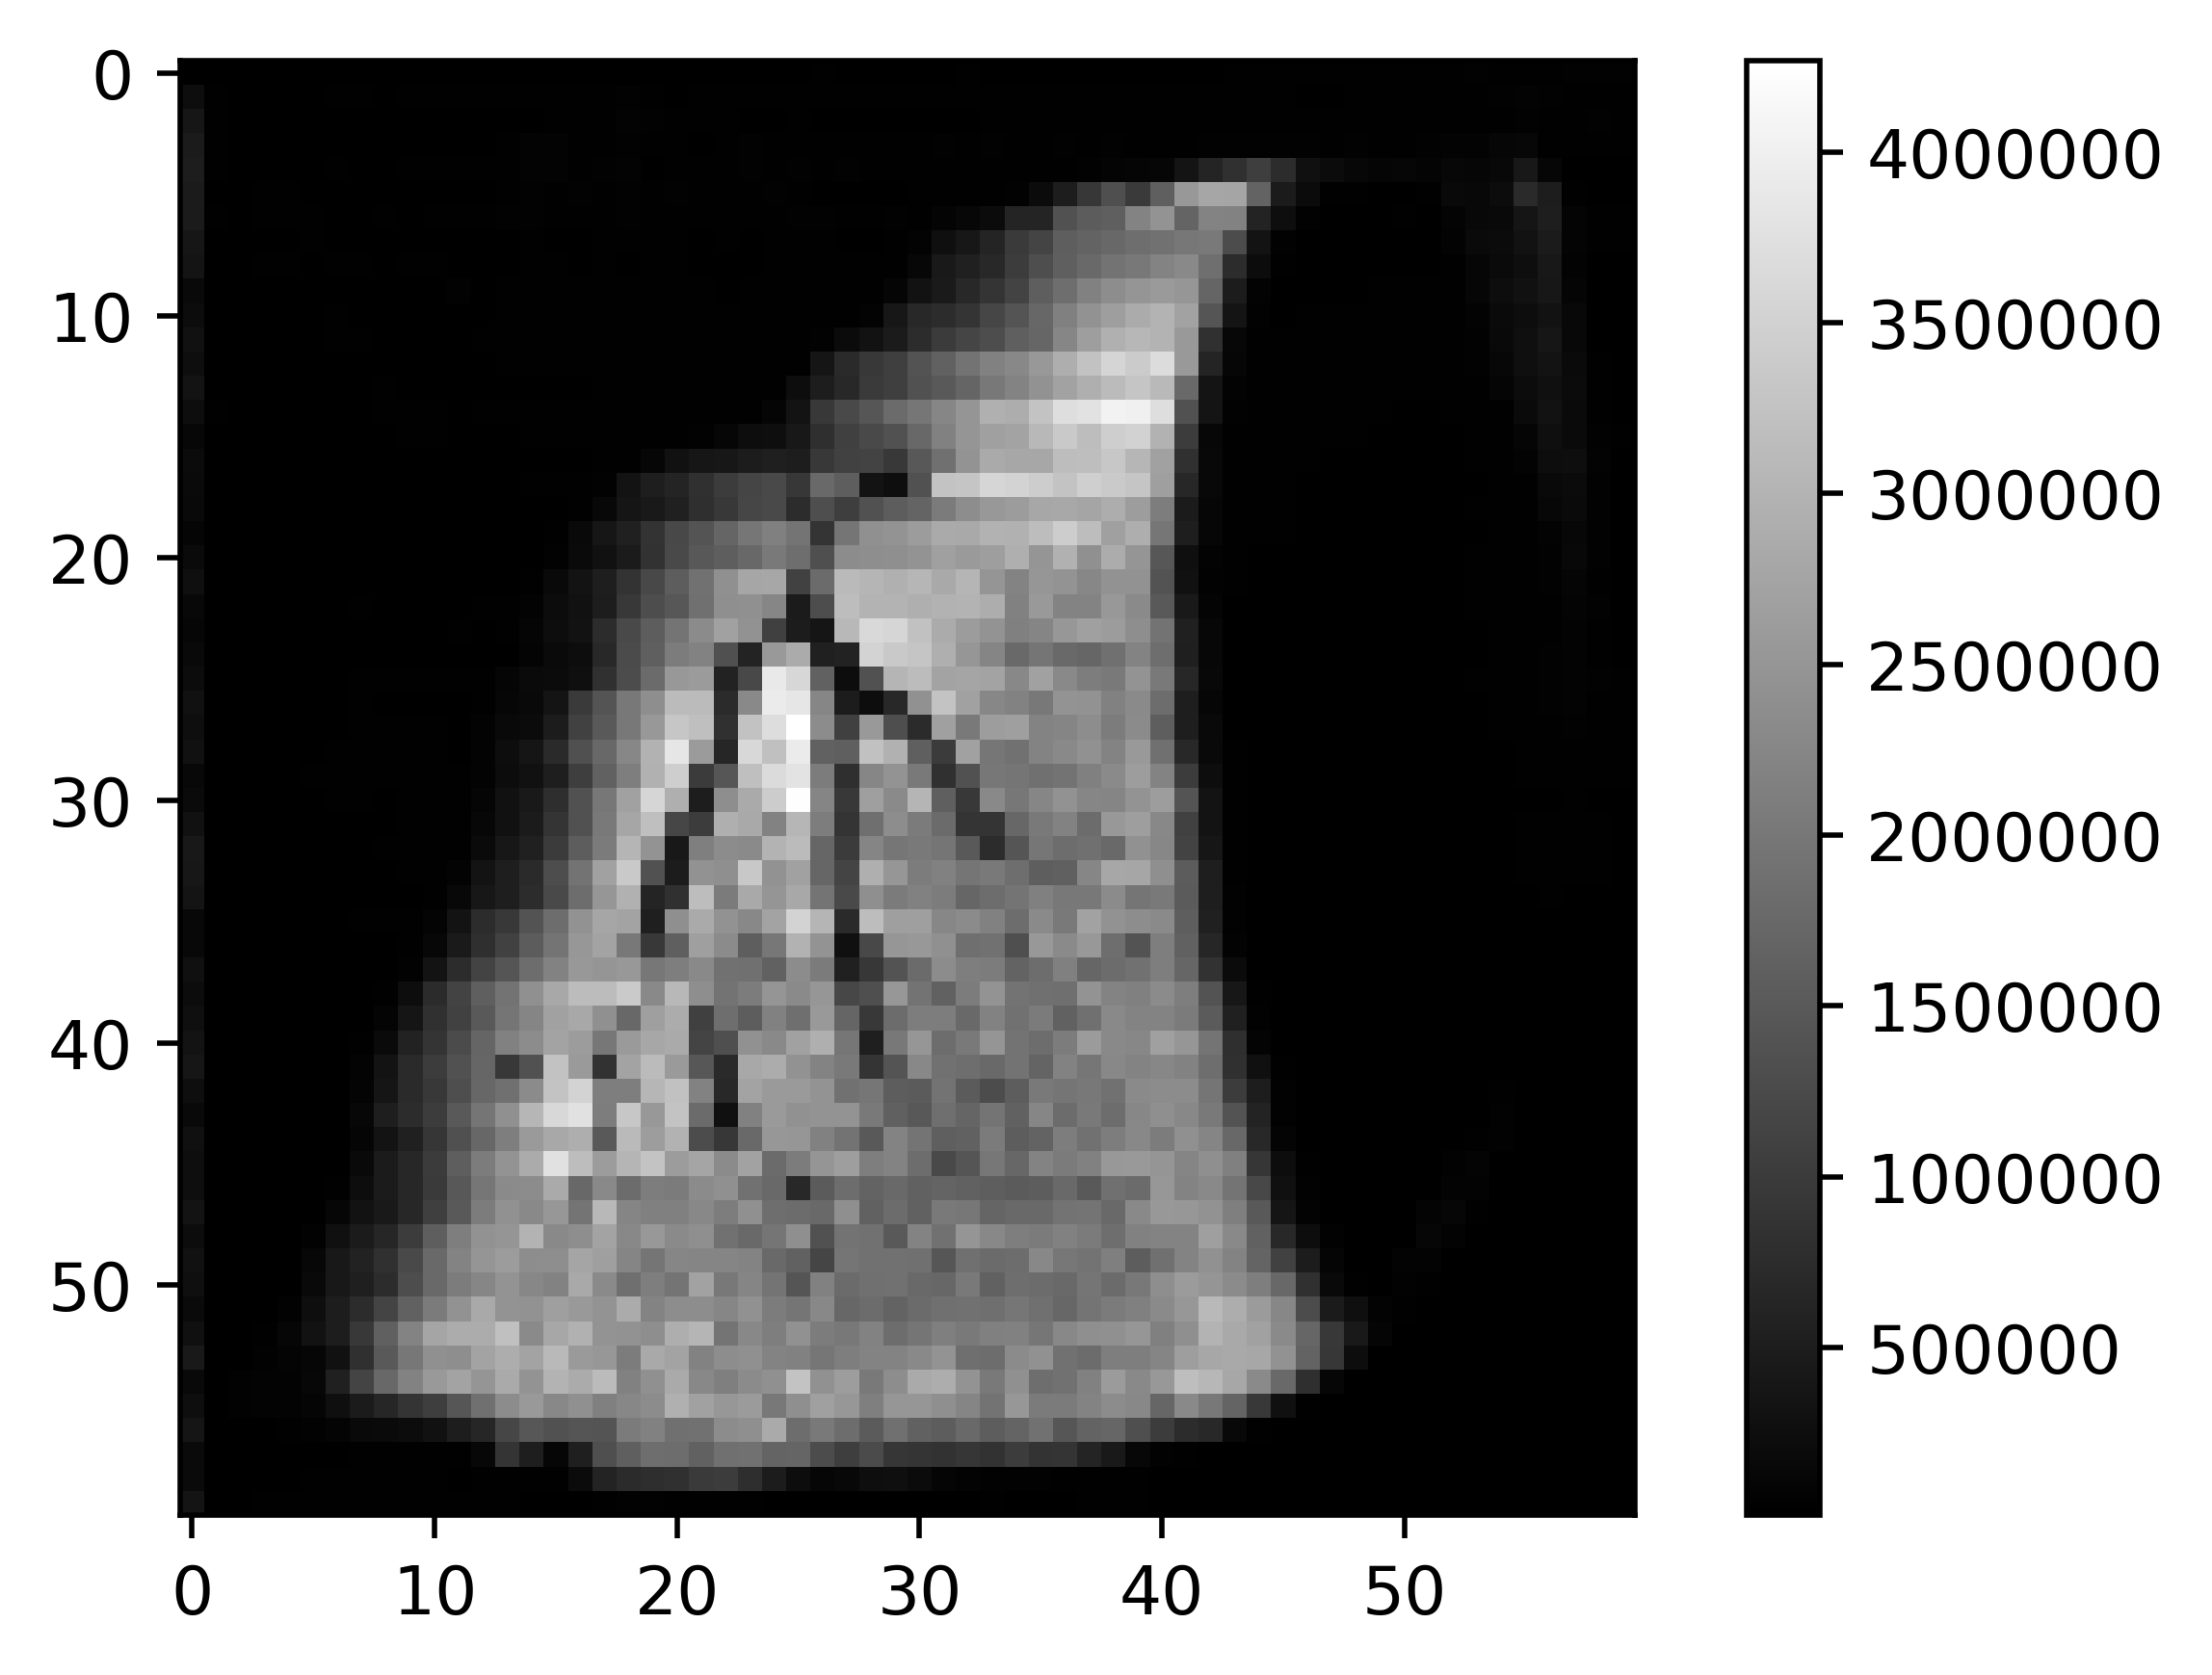

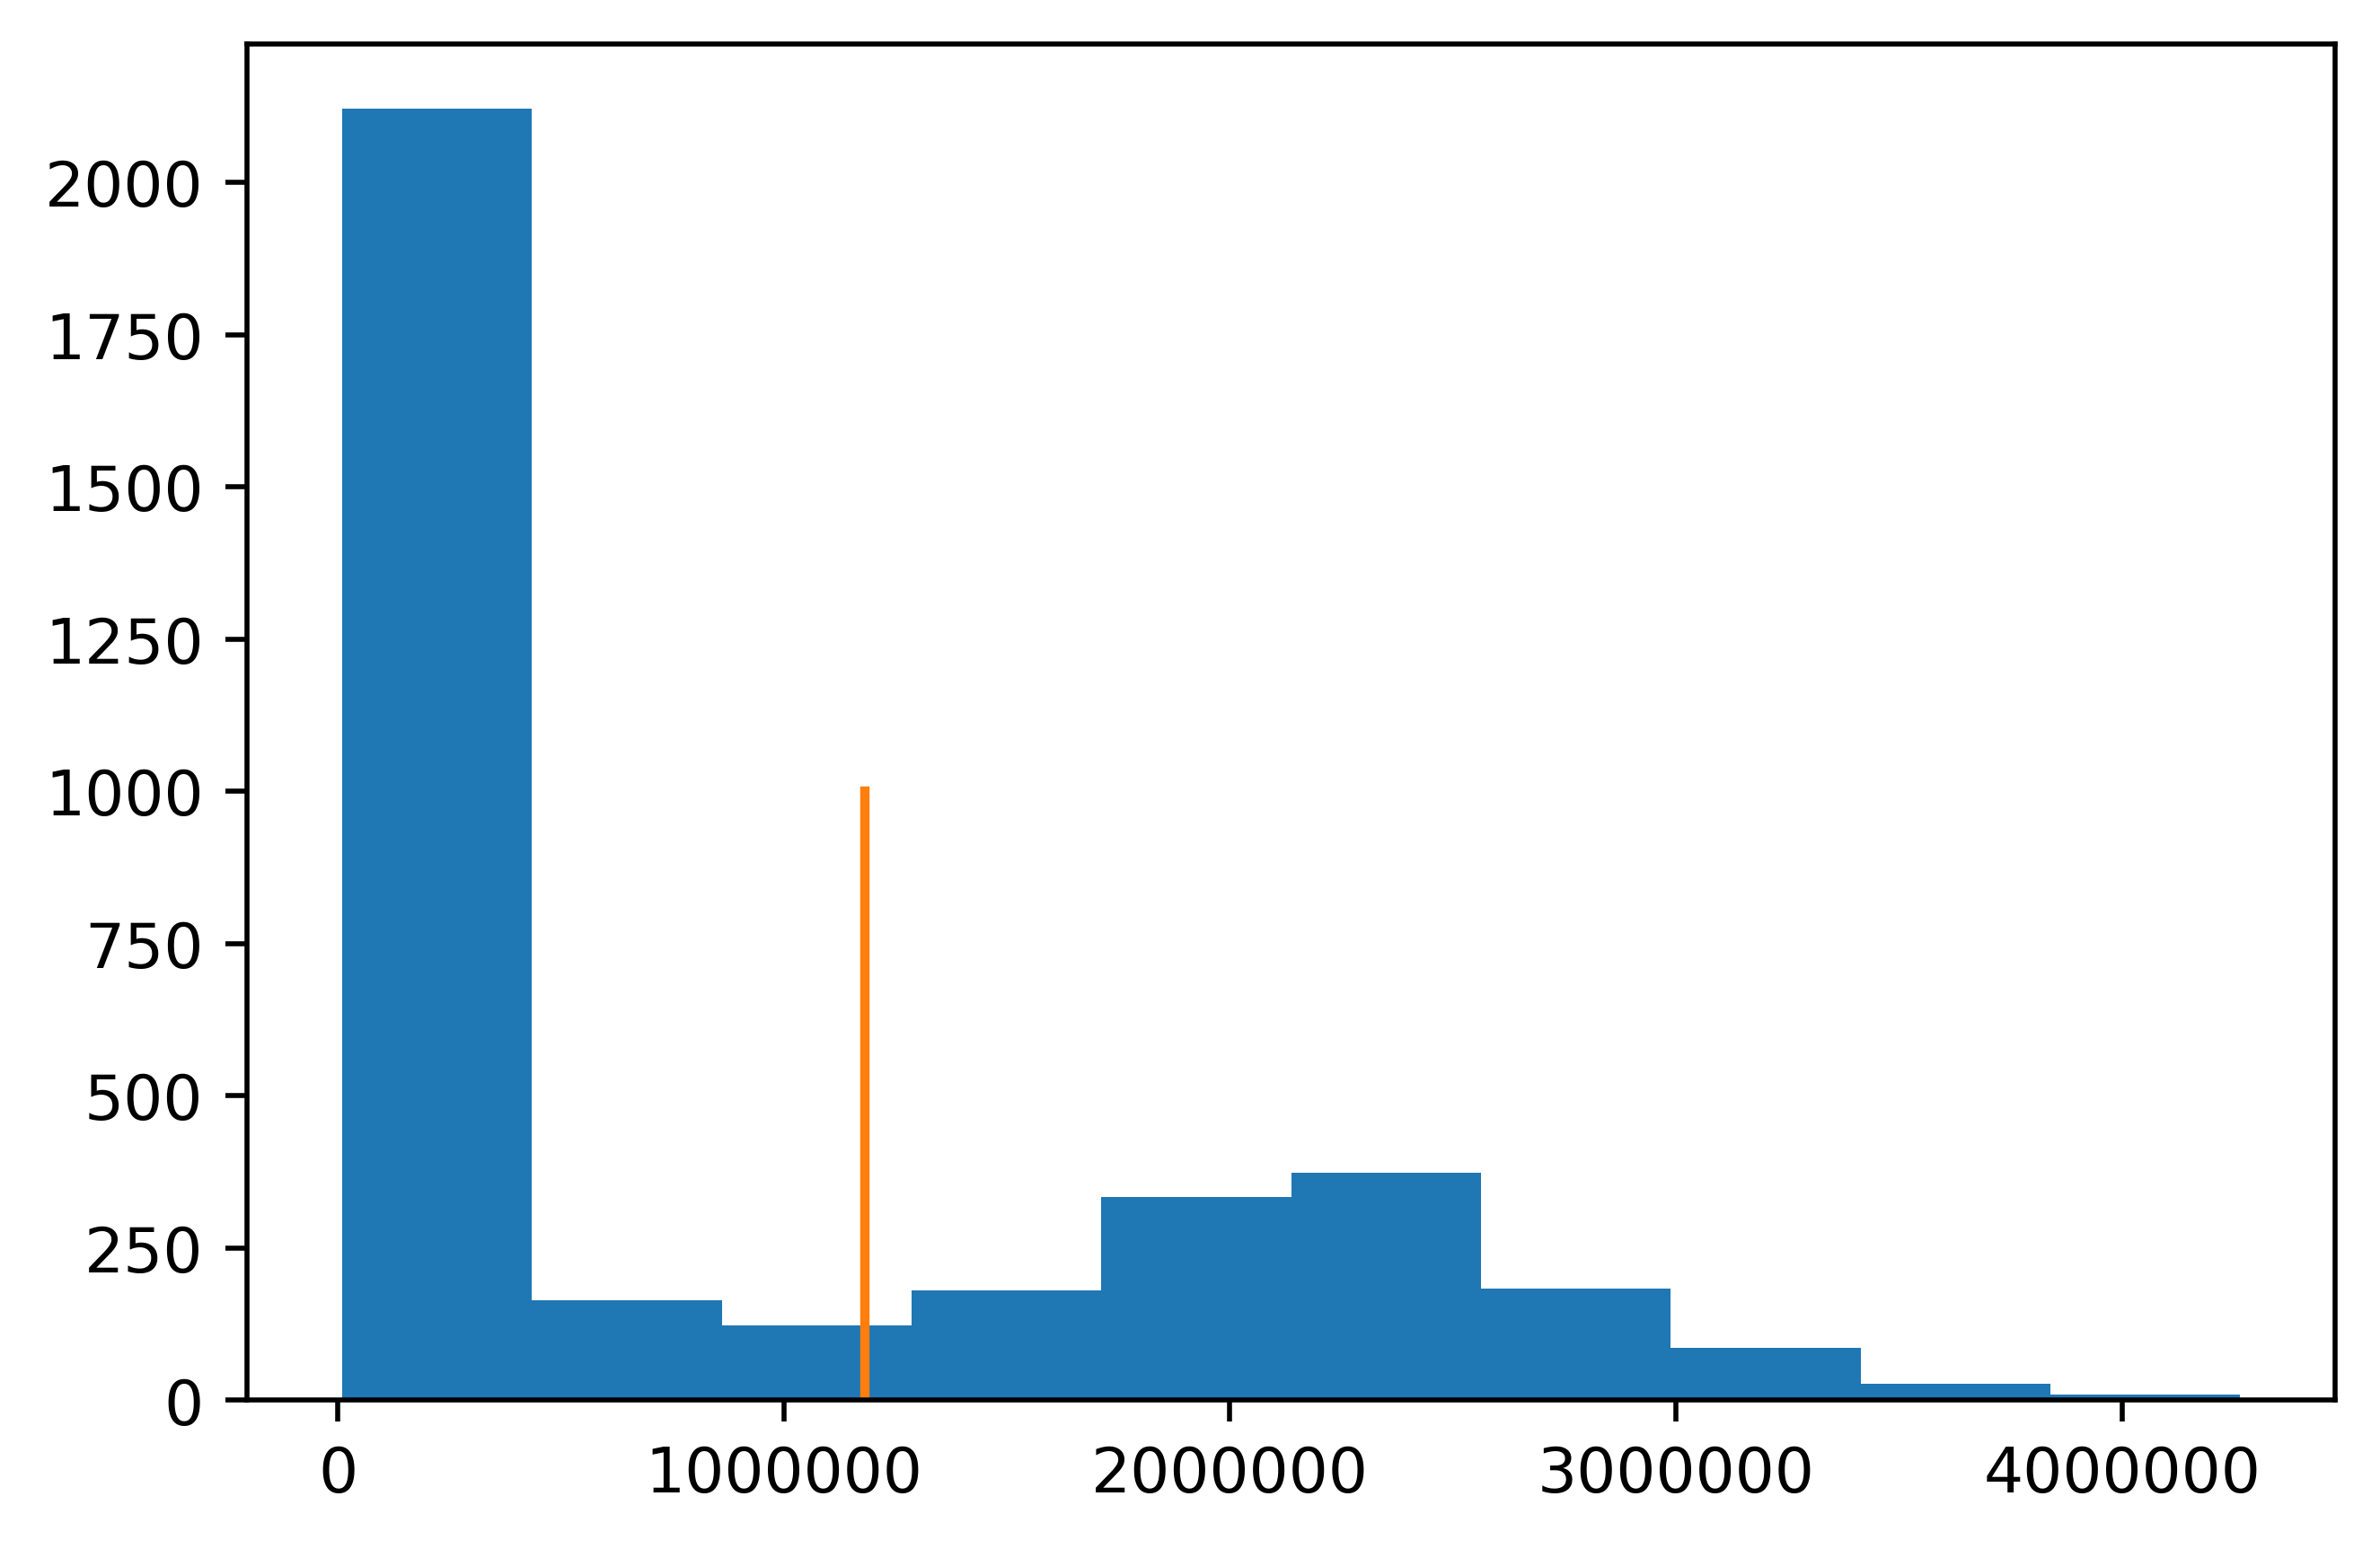

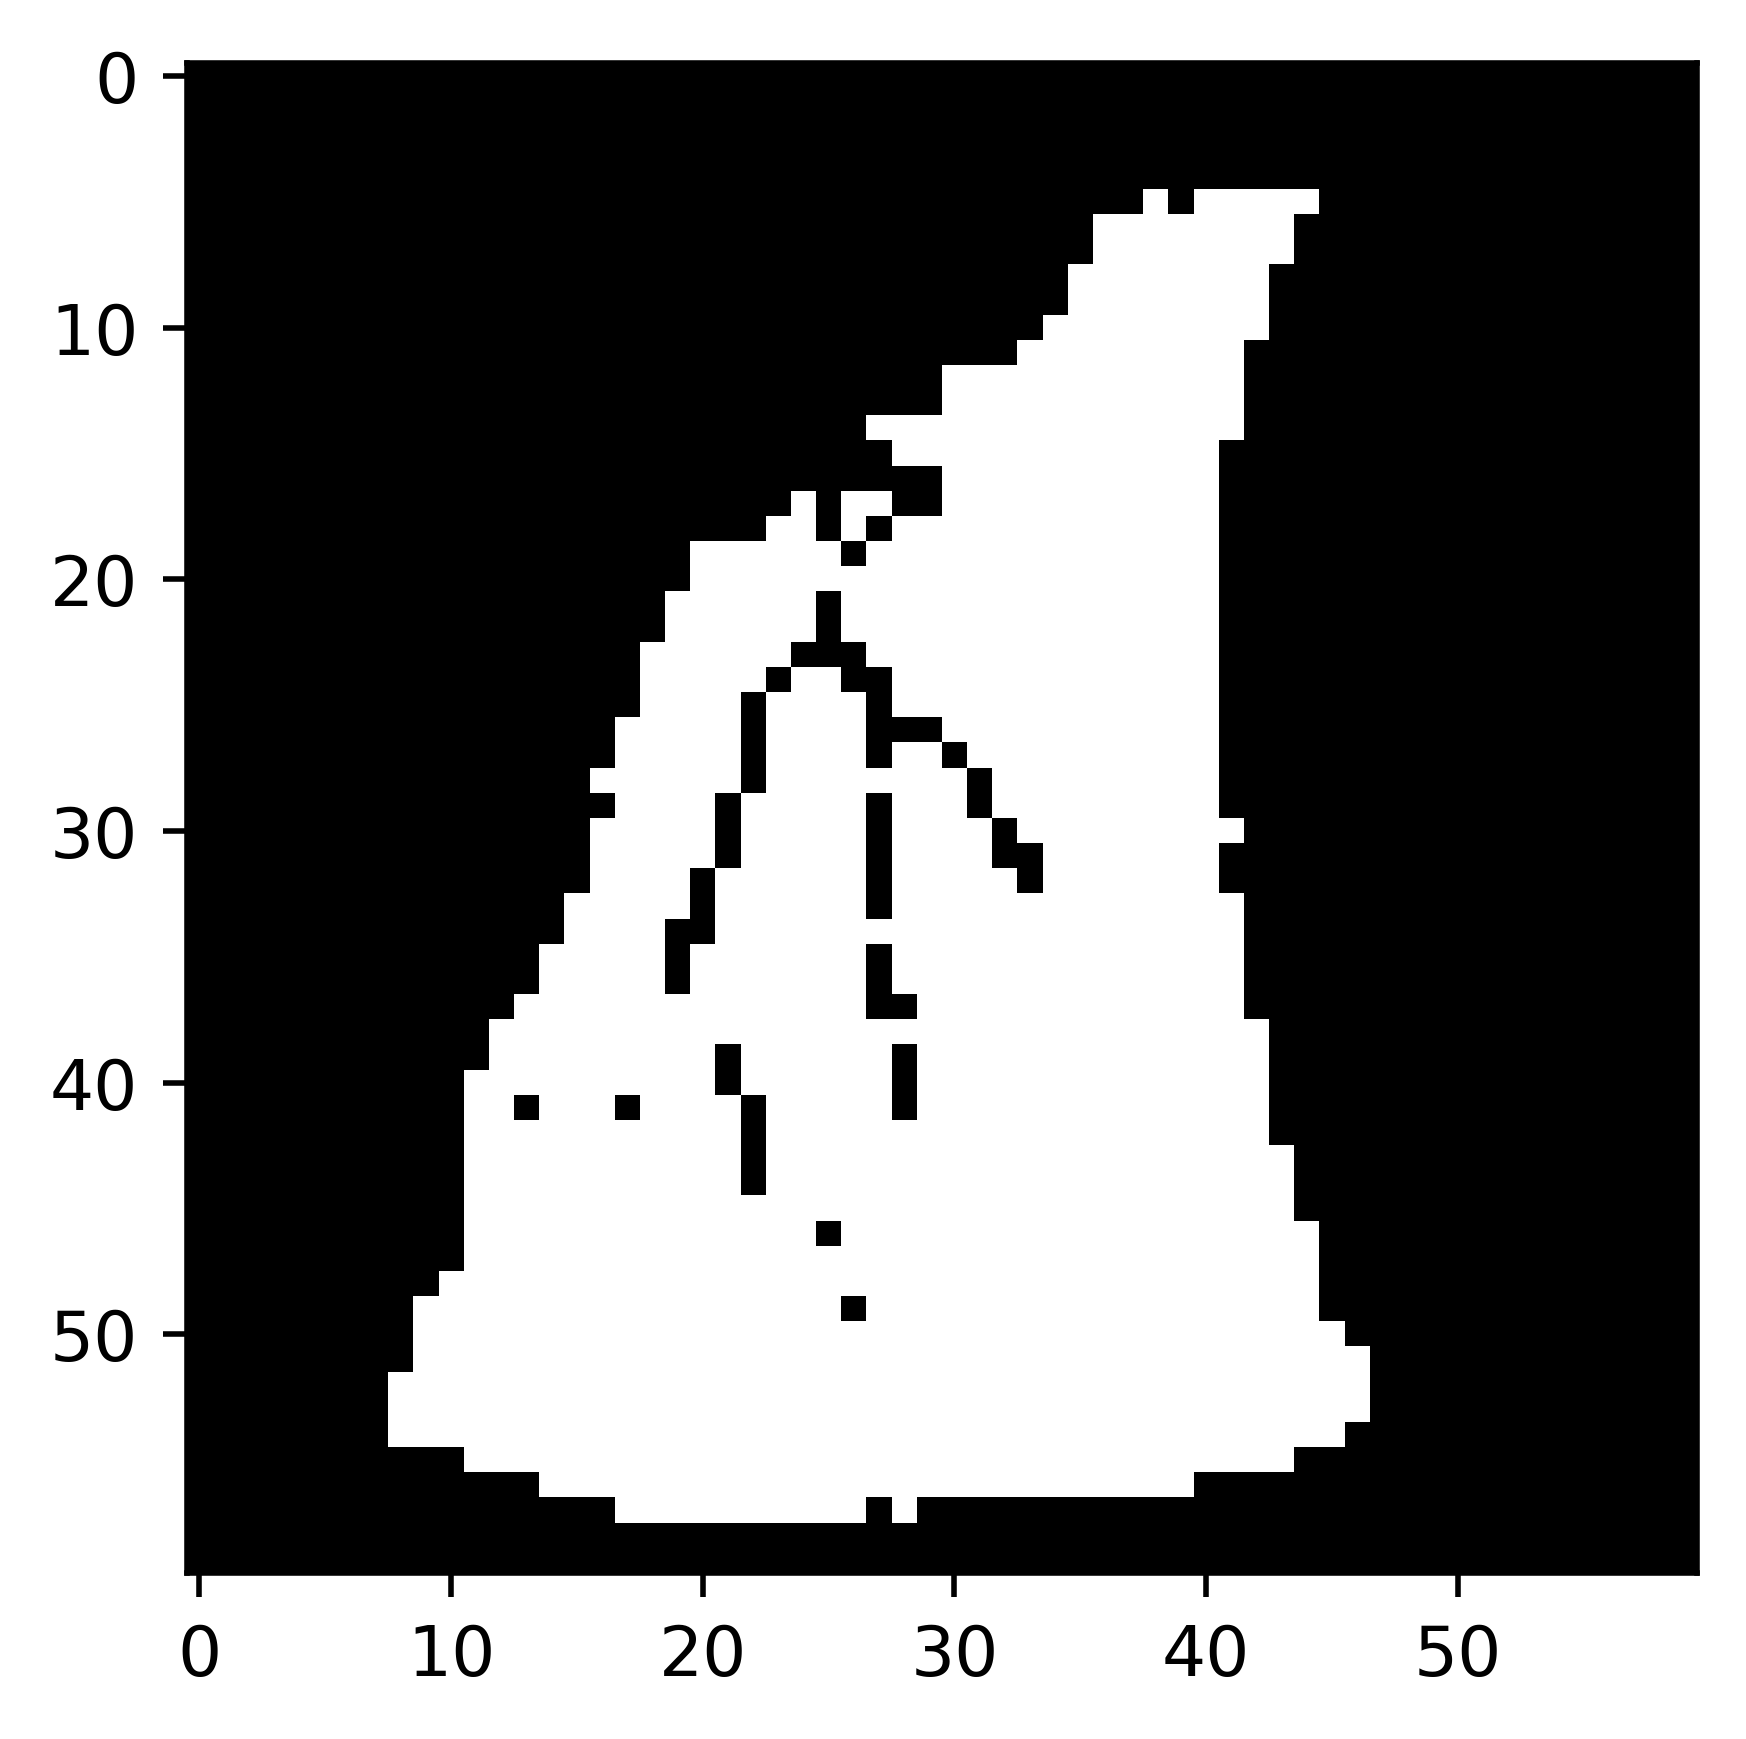

In [6]:
#get thresholded image to define sample boundary

#create TIC image

#go through all features in dataset
sumImage = np.sum([getImage(data,x,nrows,ncols) for x in mzs],axis=0)
    
plt.imshow(sumImage,cmap=colormap)
plt.colorbar()
plt.figure()
plt.hist(sumImage.flatten())

threshold = skimage.filters.threshold_otsu(sumImage)

imageBoundary = sumImage > threshold

plt.plot([threshold,threshold],[0,1000])

plt.figure()

plt.imshow(imageBoundary,cmap=colormap)


offset = int((convSquare-1)/2)
tensorFilt = np.zeros((len(tensor),nrows-2*offset,ncols-2*offset))
newImageBoundary = np.zeros((nrows-2*offset,ncols-2*offset))
for r in range(offset,nrows-offset):
    for c in range(offset,ncols-offset):
        newImageBoundary[r-offset:r+offset+1,c-offset:c+offset+1] = imageBoundary[r,c]
        for t in range(len(tensor)):
            tempMat = tensor[t,r-offset:r+offset+1,c-offset:c+offset+1]
            coef = imageBoundary[r-offset:r+offset+1,c-offset:c+offset+1]
            coef = coef / max([1,np.sum(coef)])
            tensorFilt[t,r-offset,c-offset] = np.sum(np.multiply(tempMat,coef))

normalizeTensor(tensorFilt)

[0.02115921 0.1563529  0.82248789]


Text(0.5, 1.0, 'D')

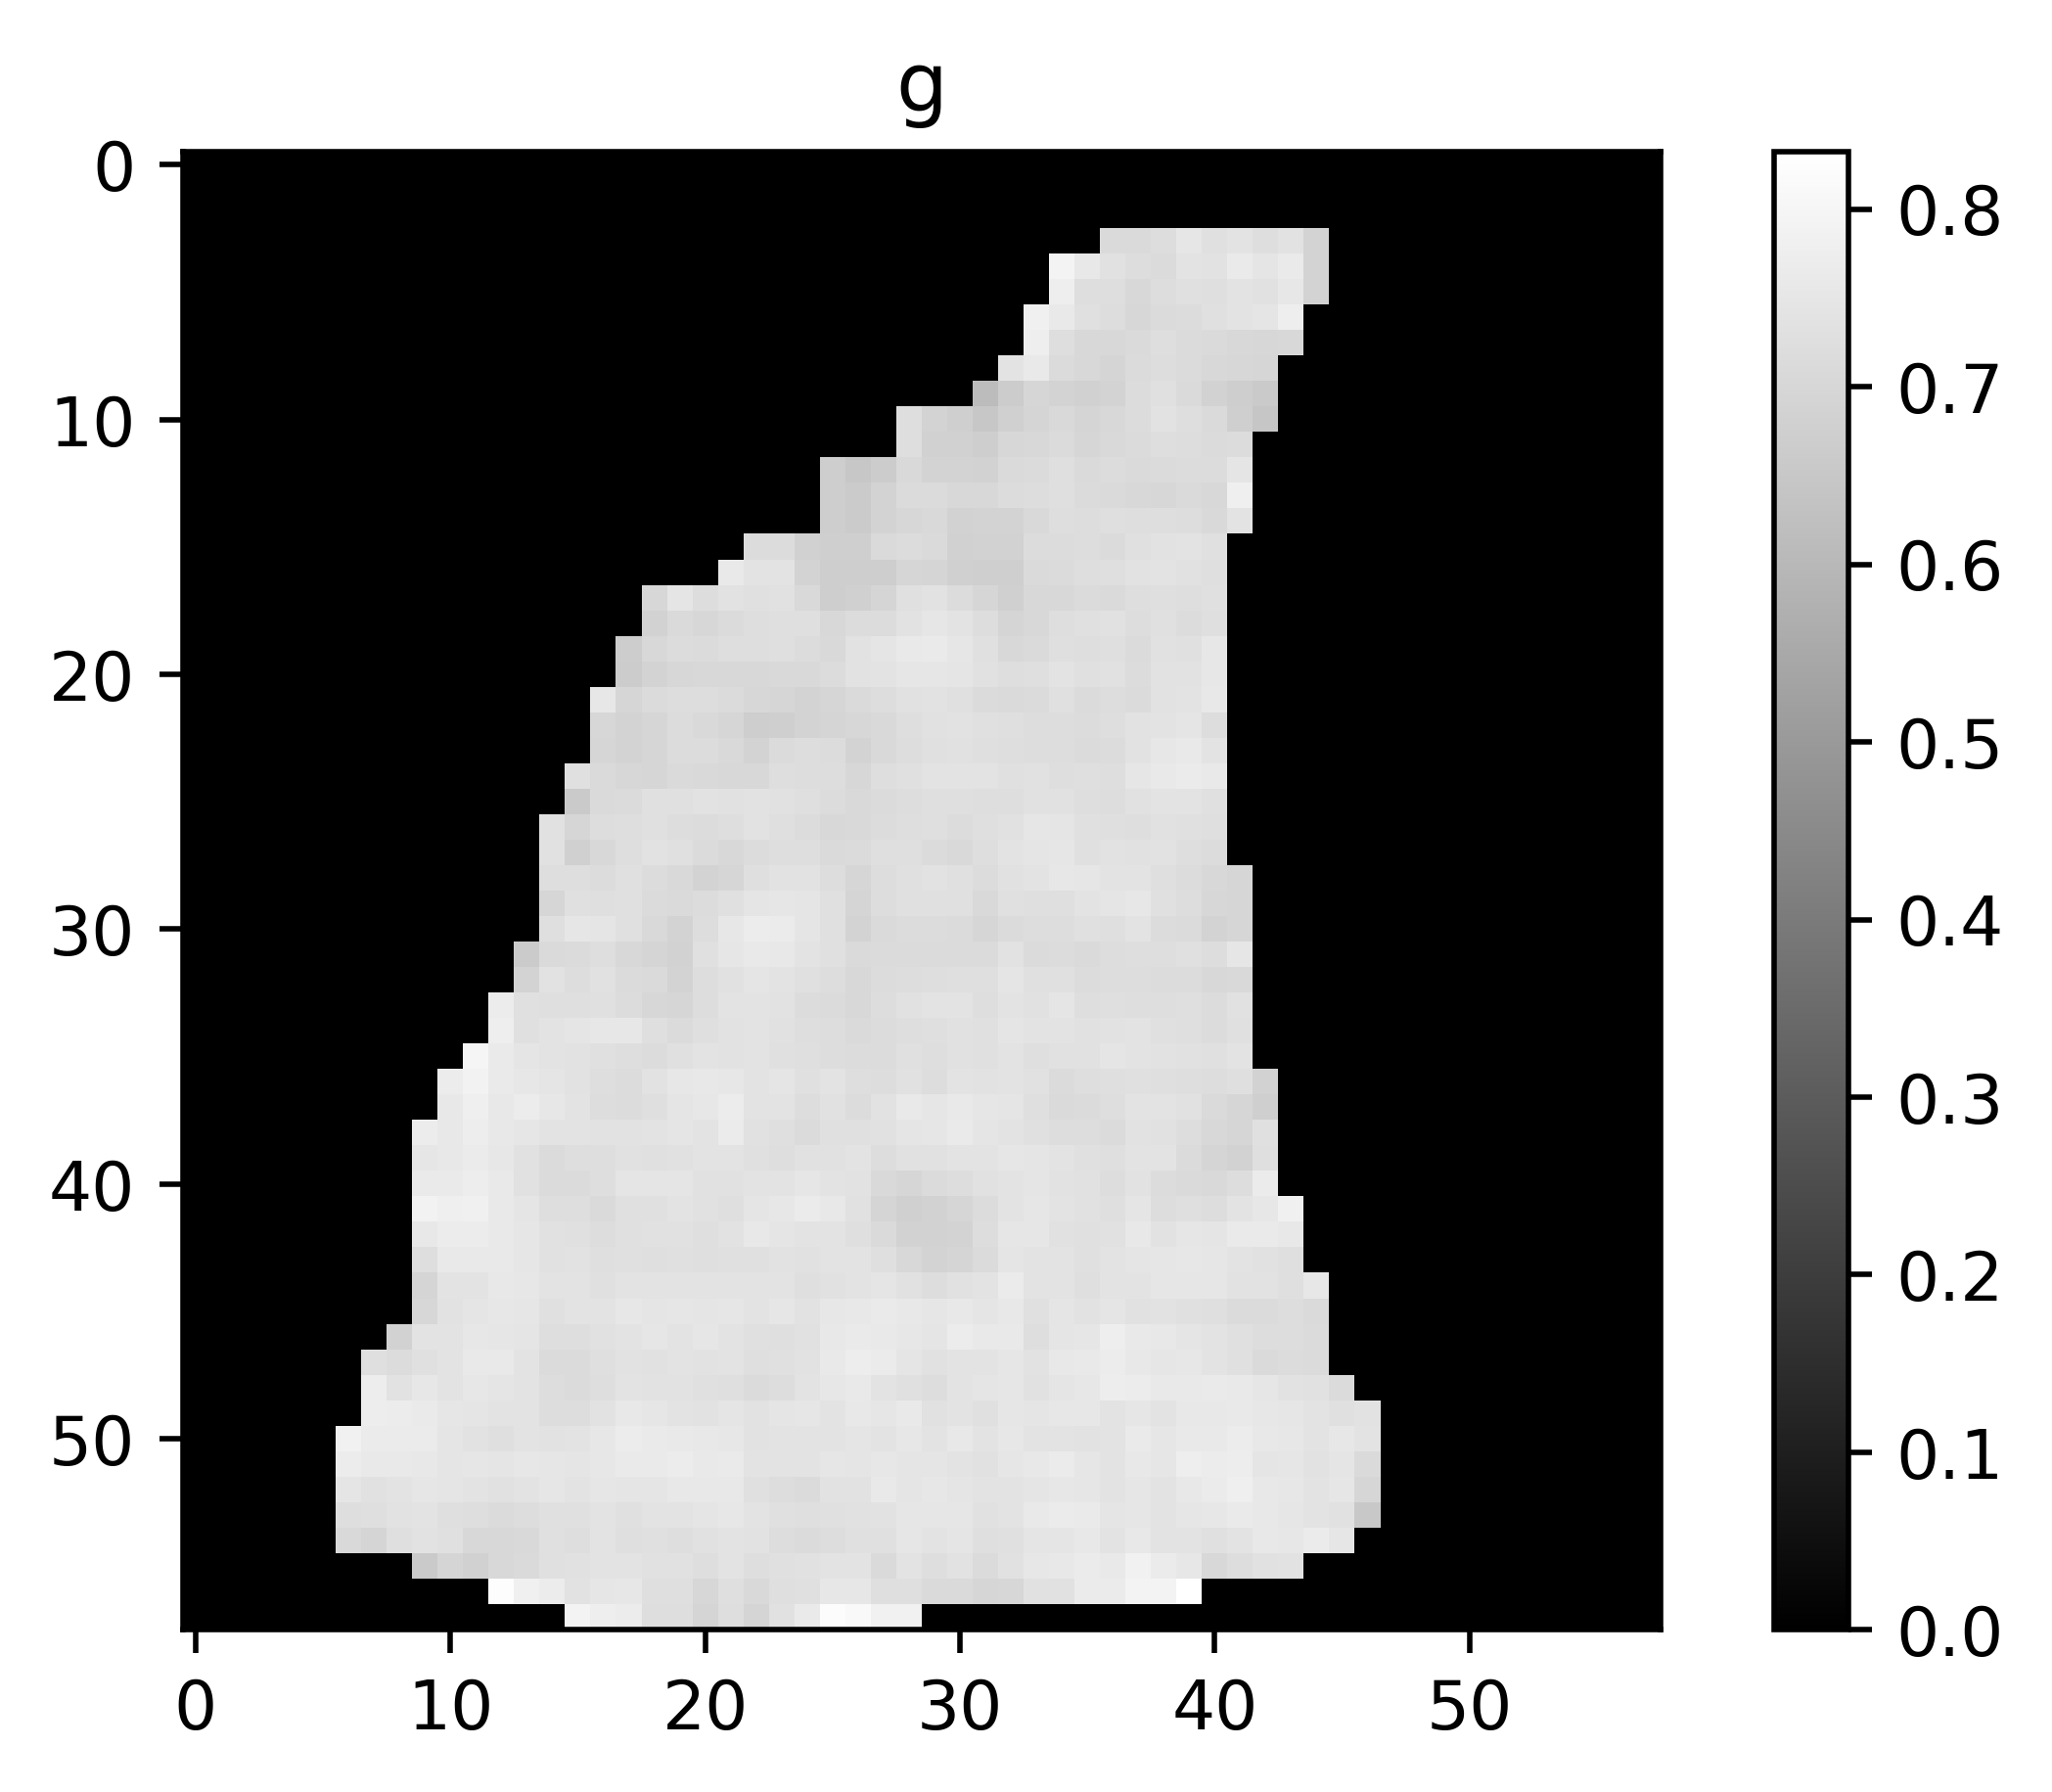

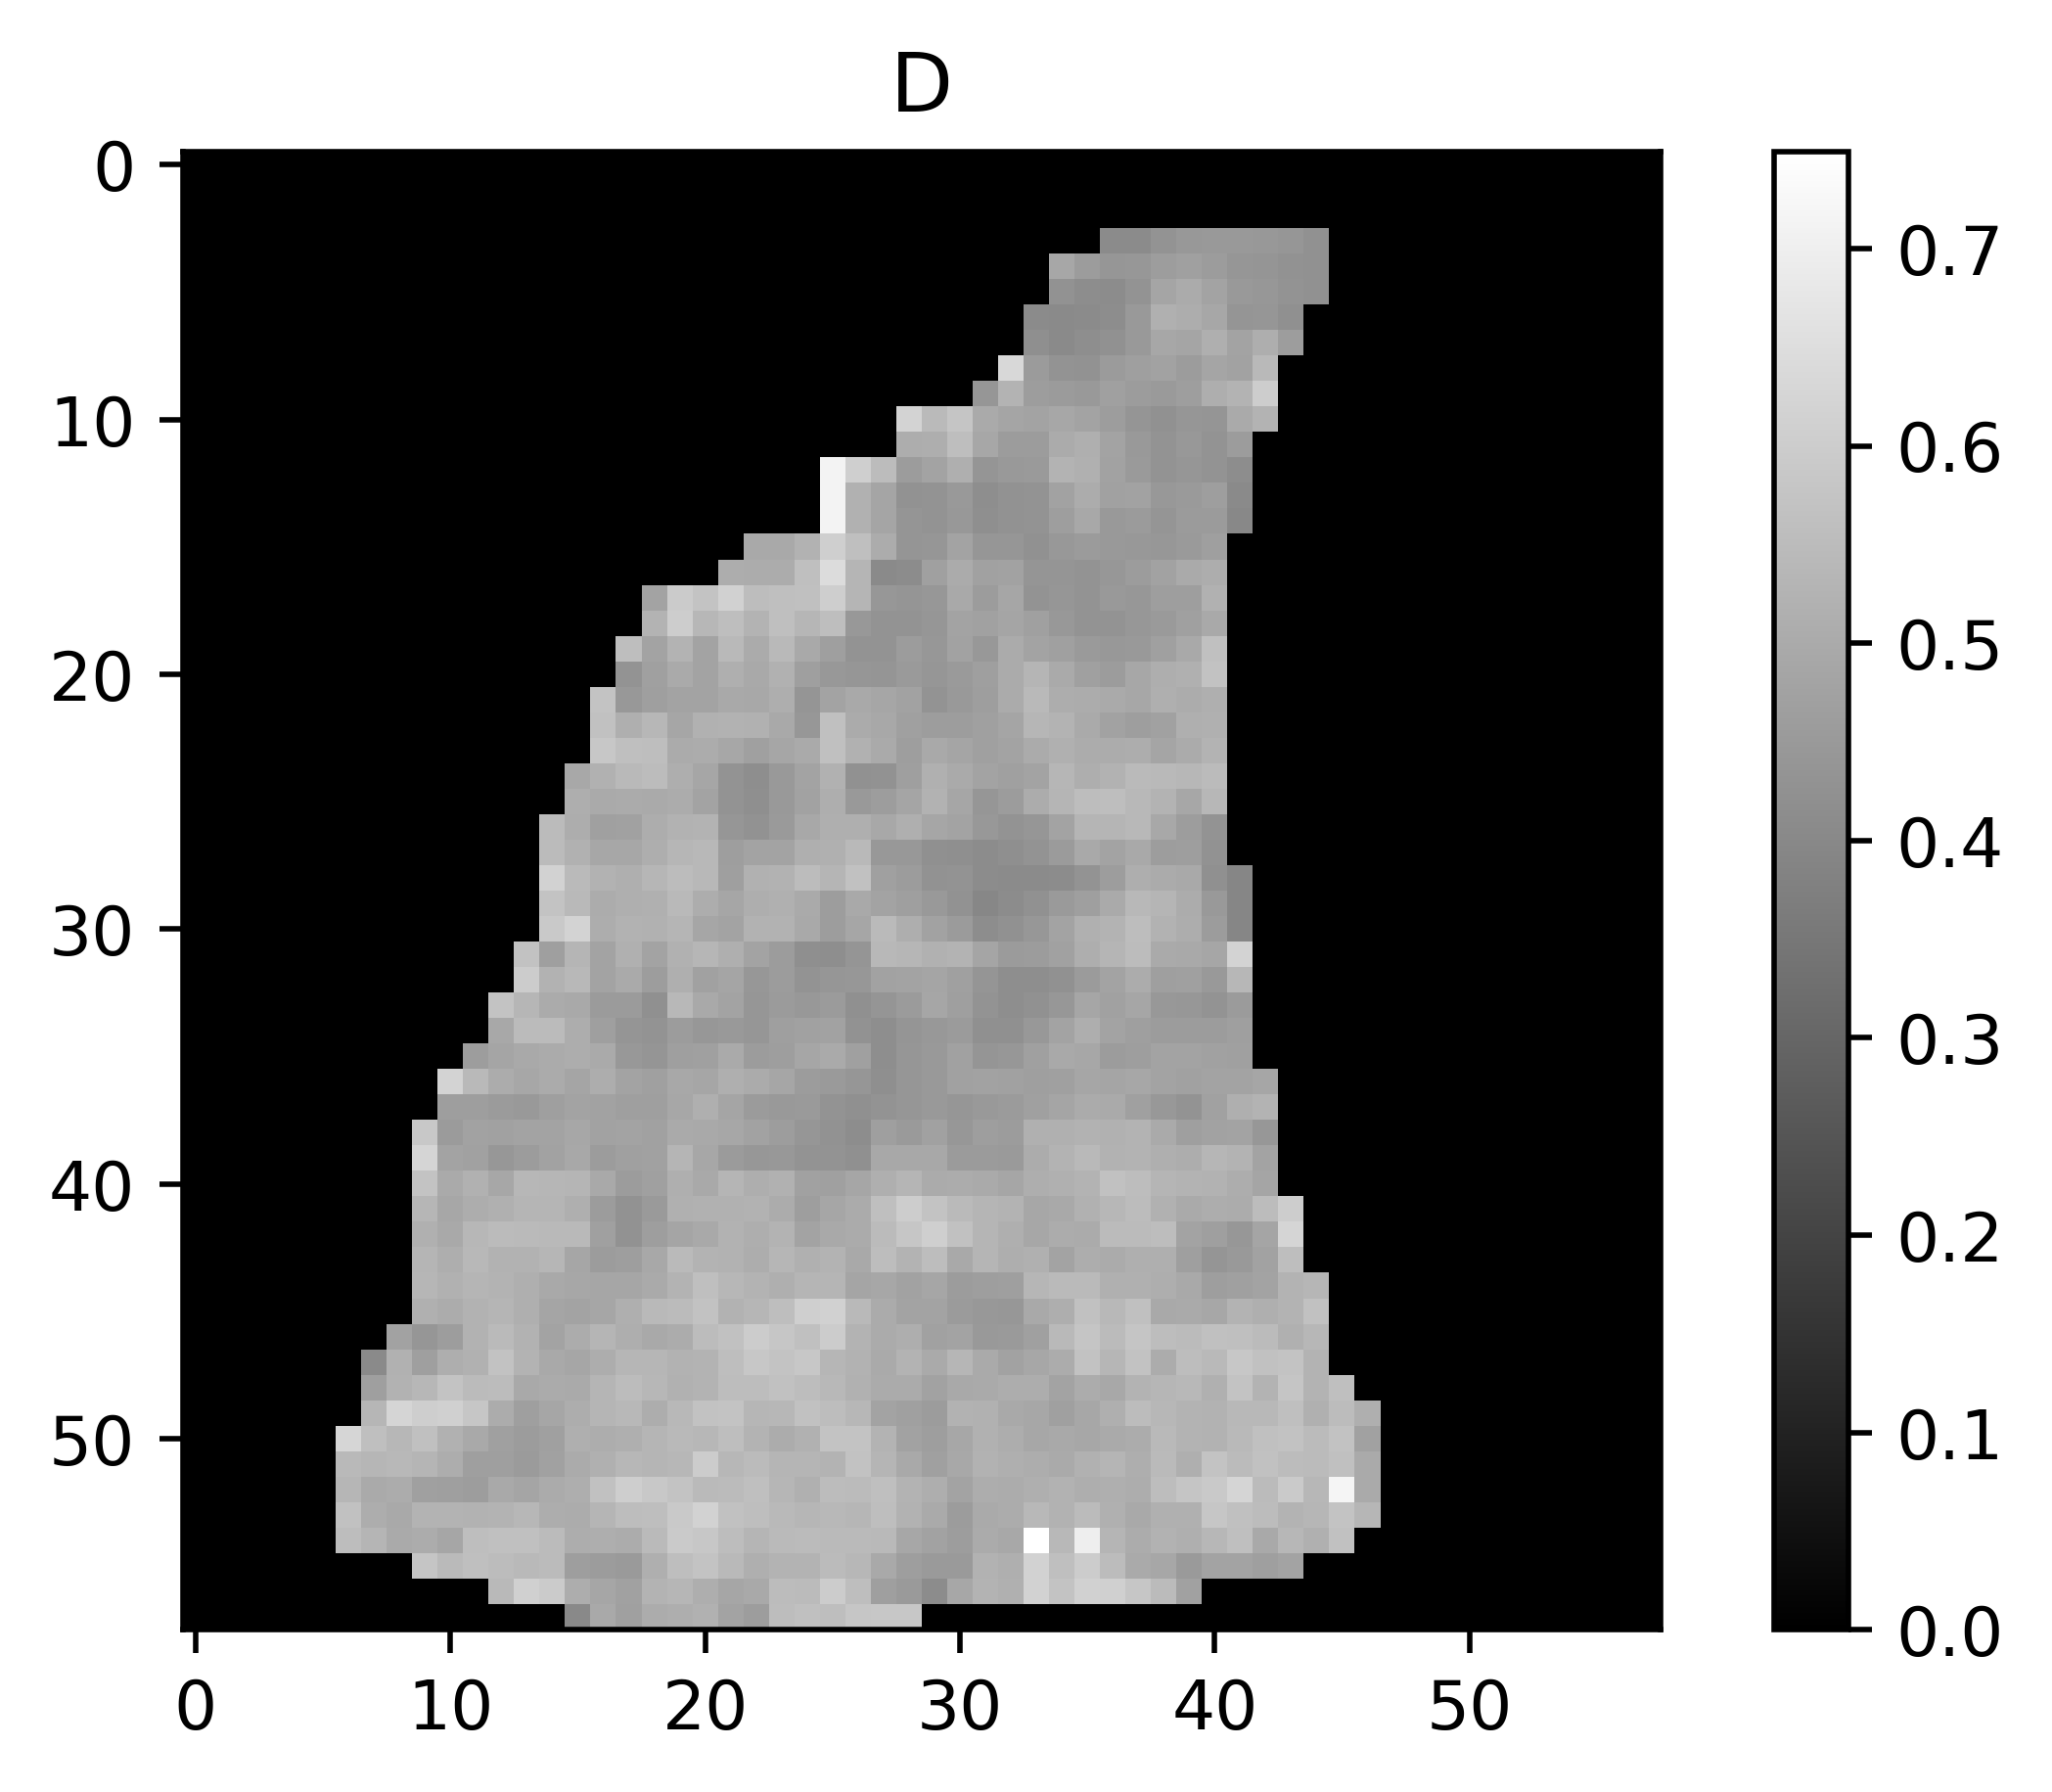

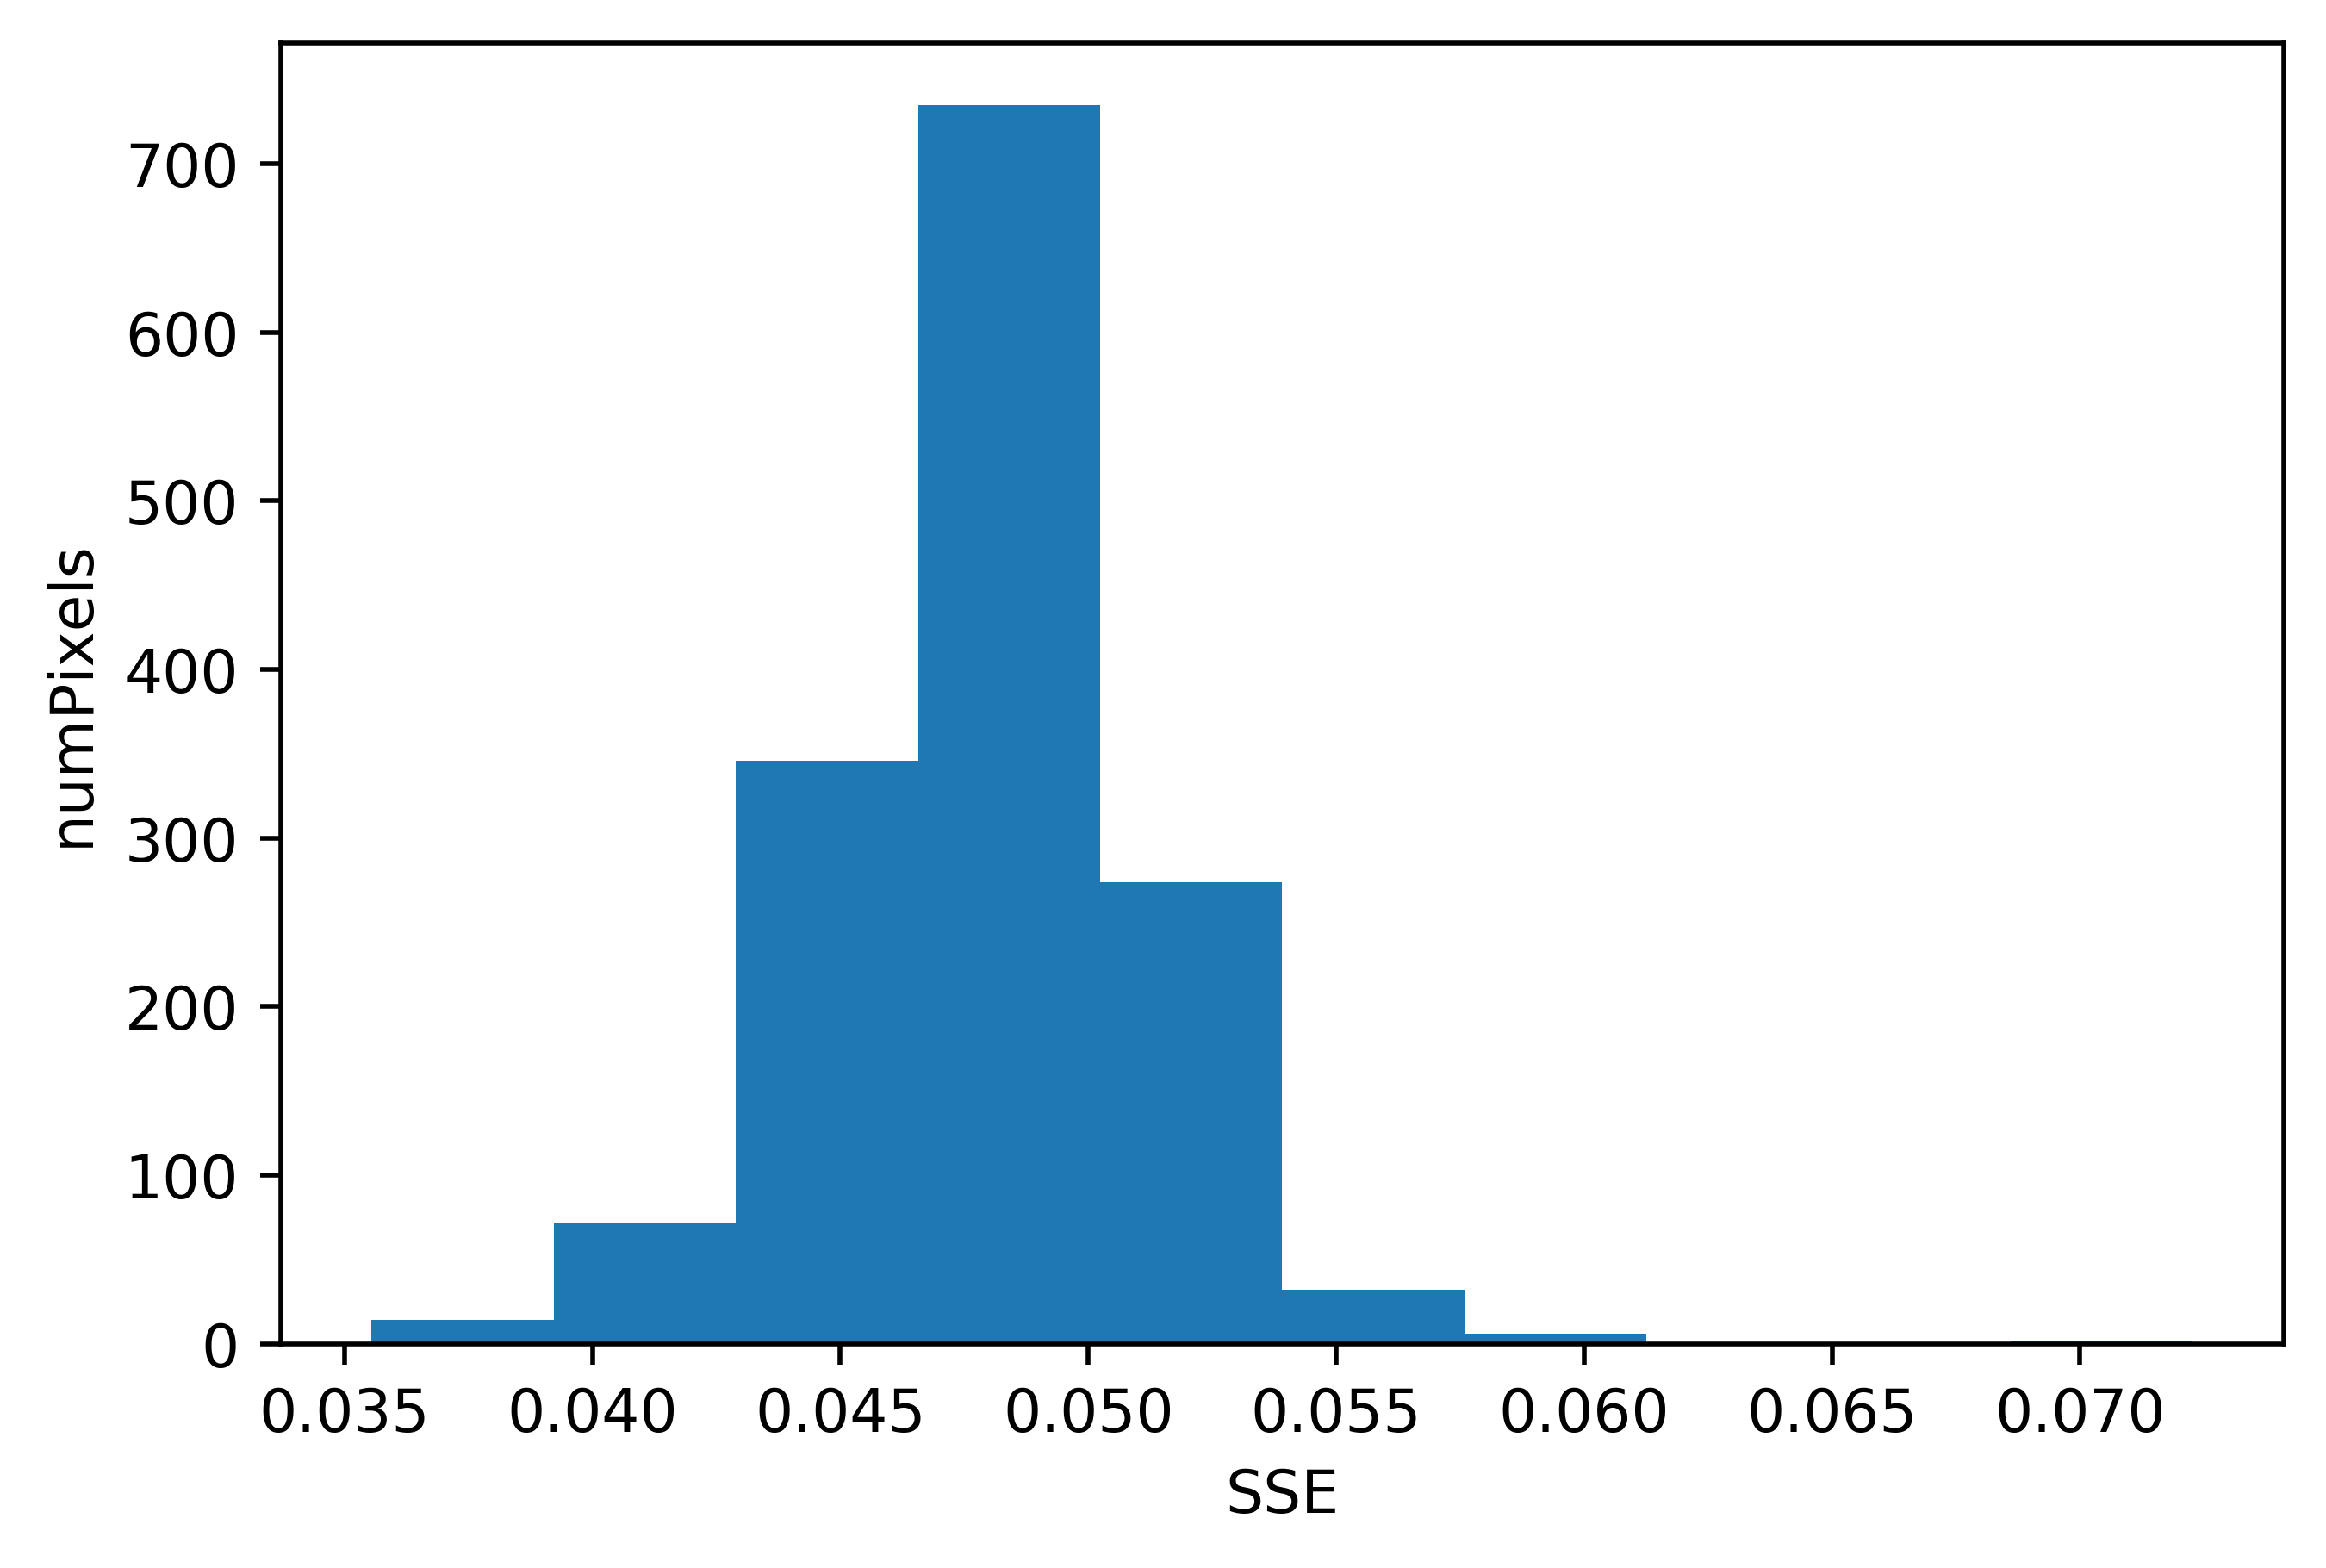

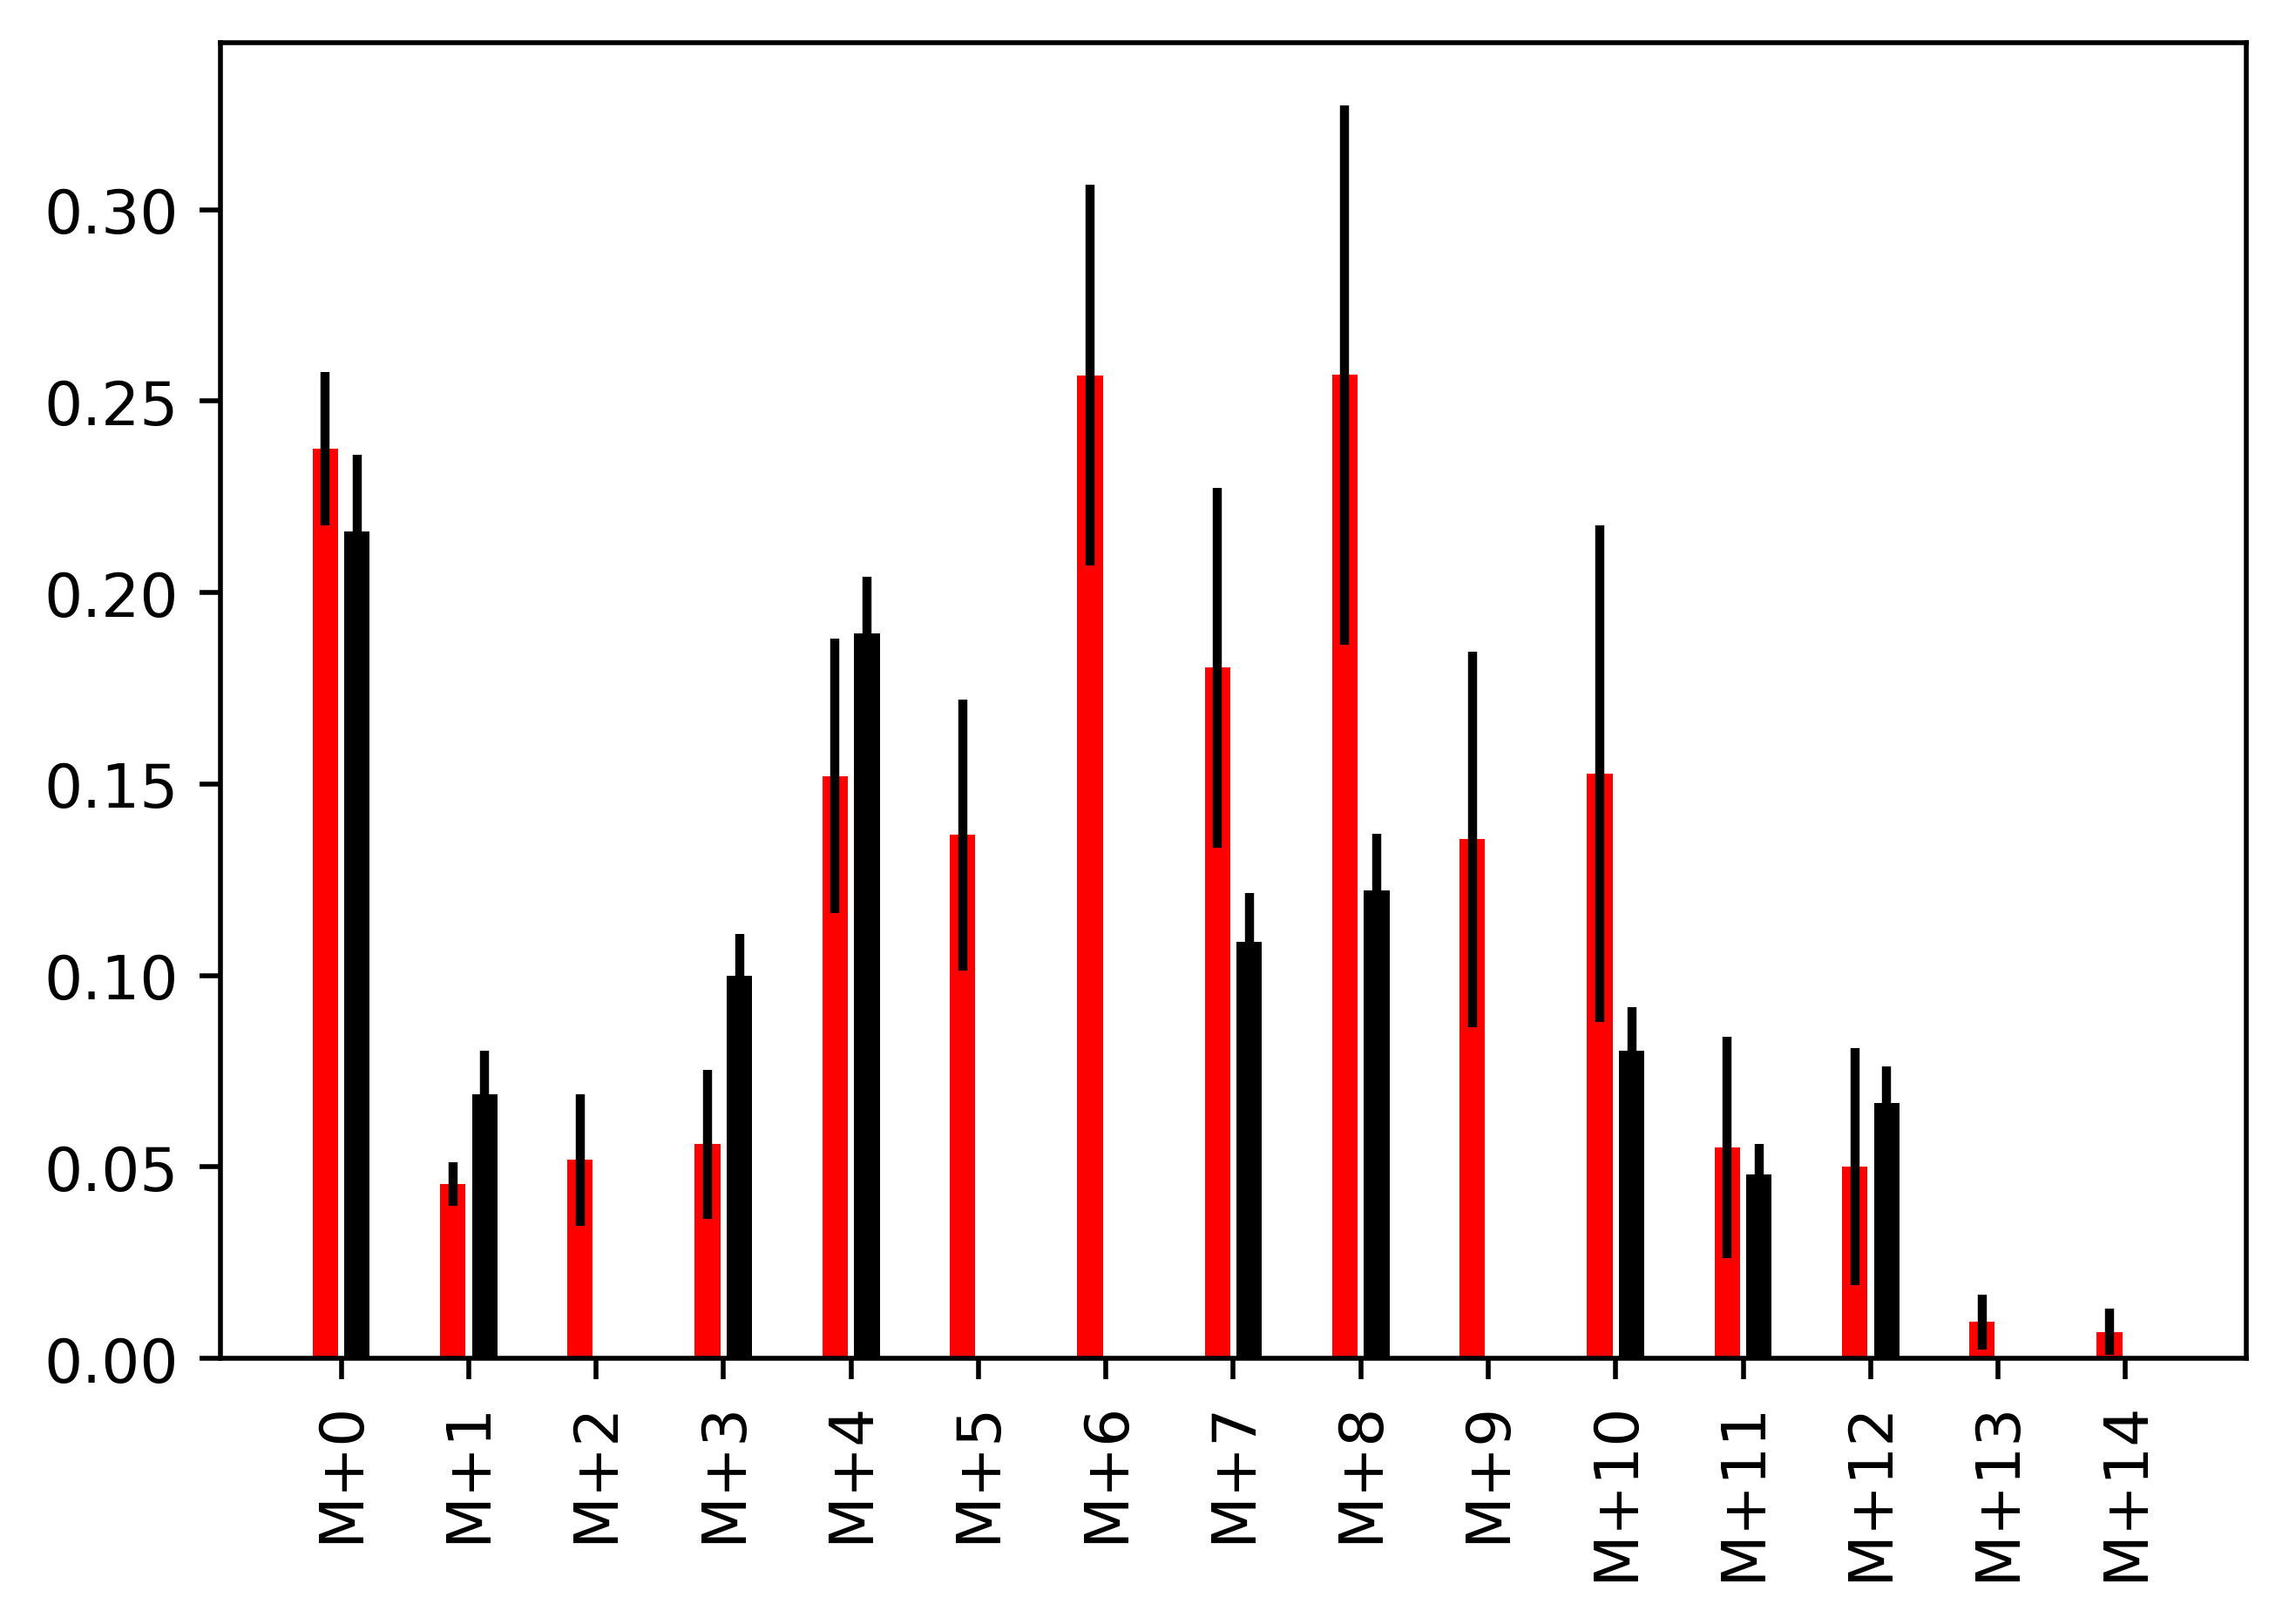

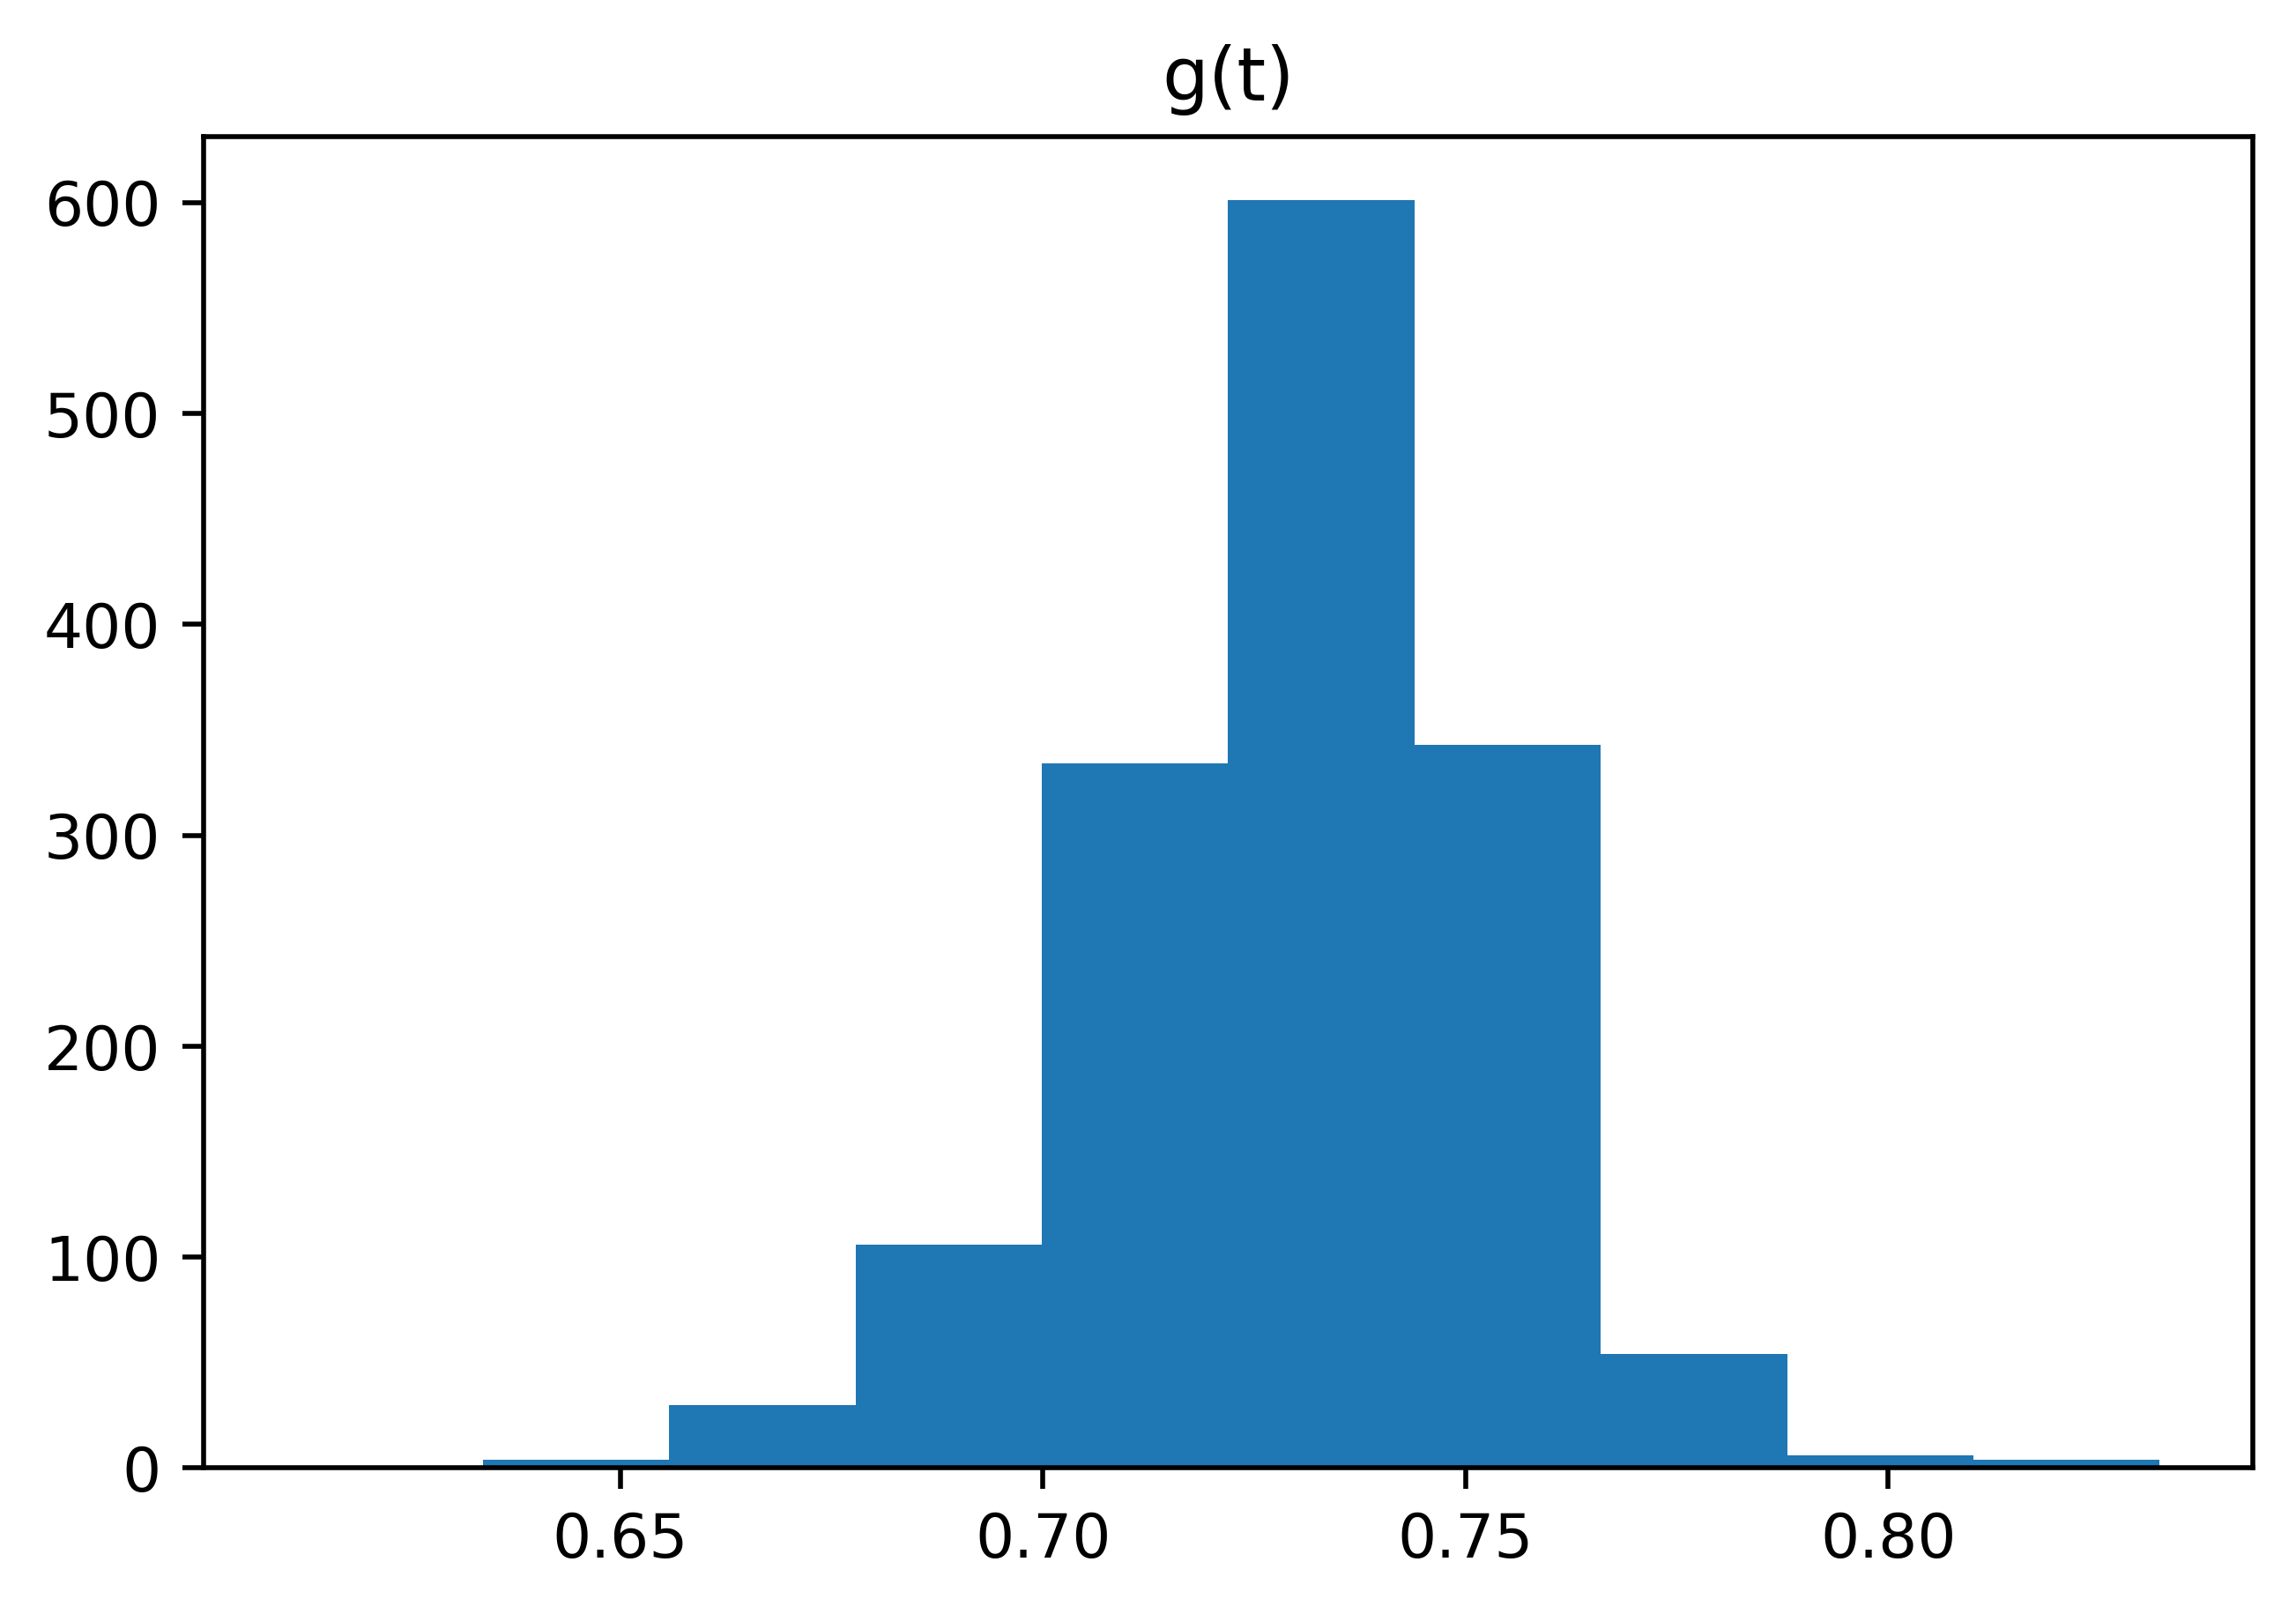

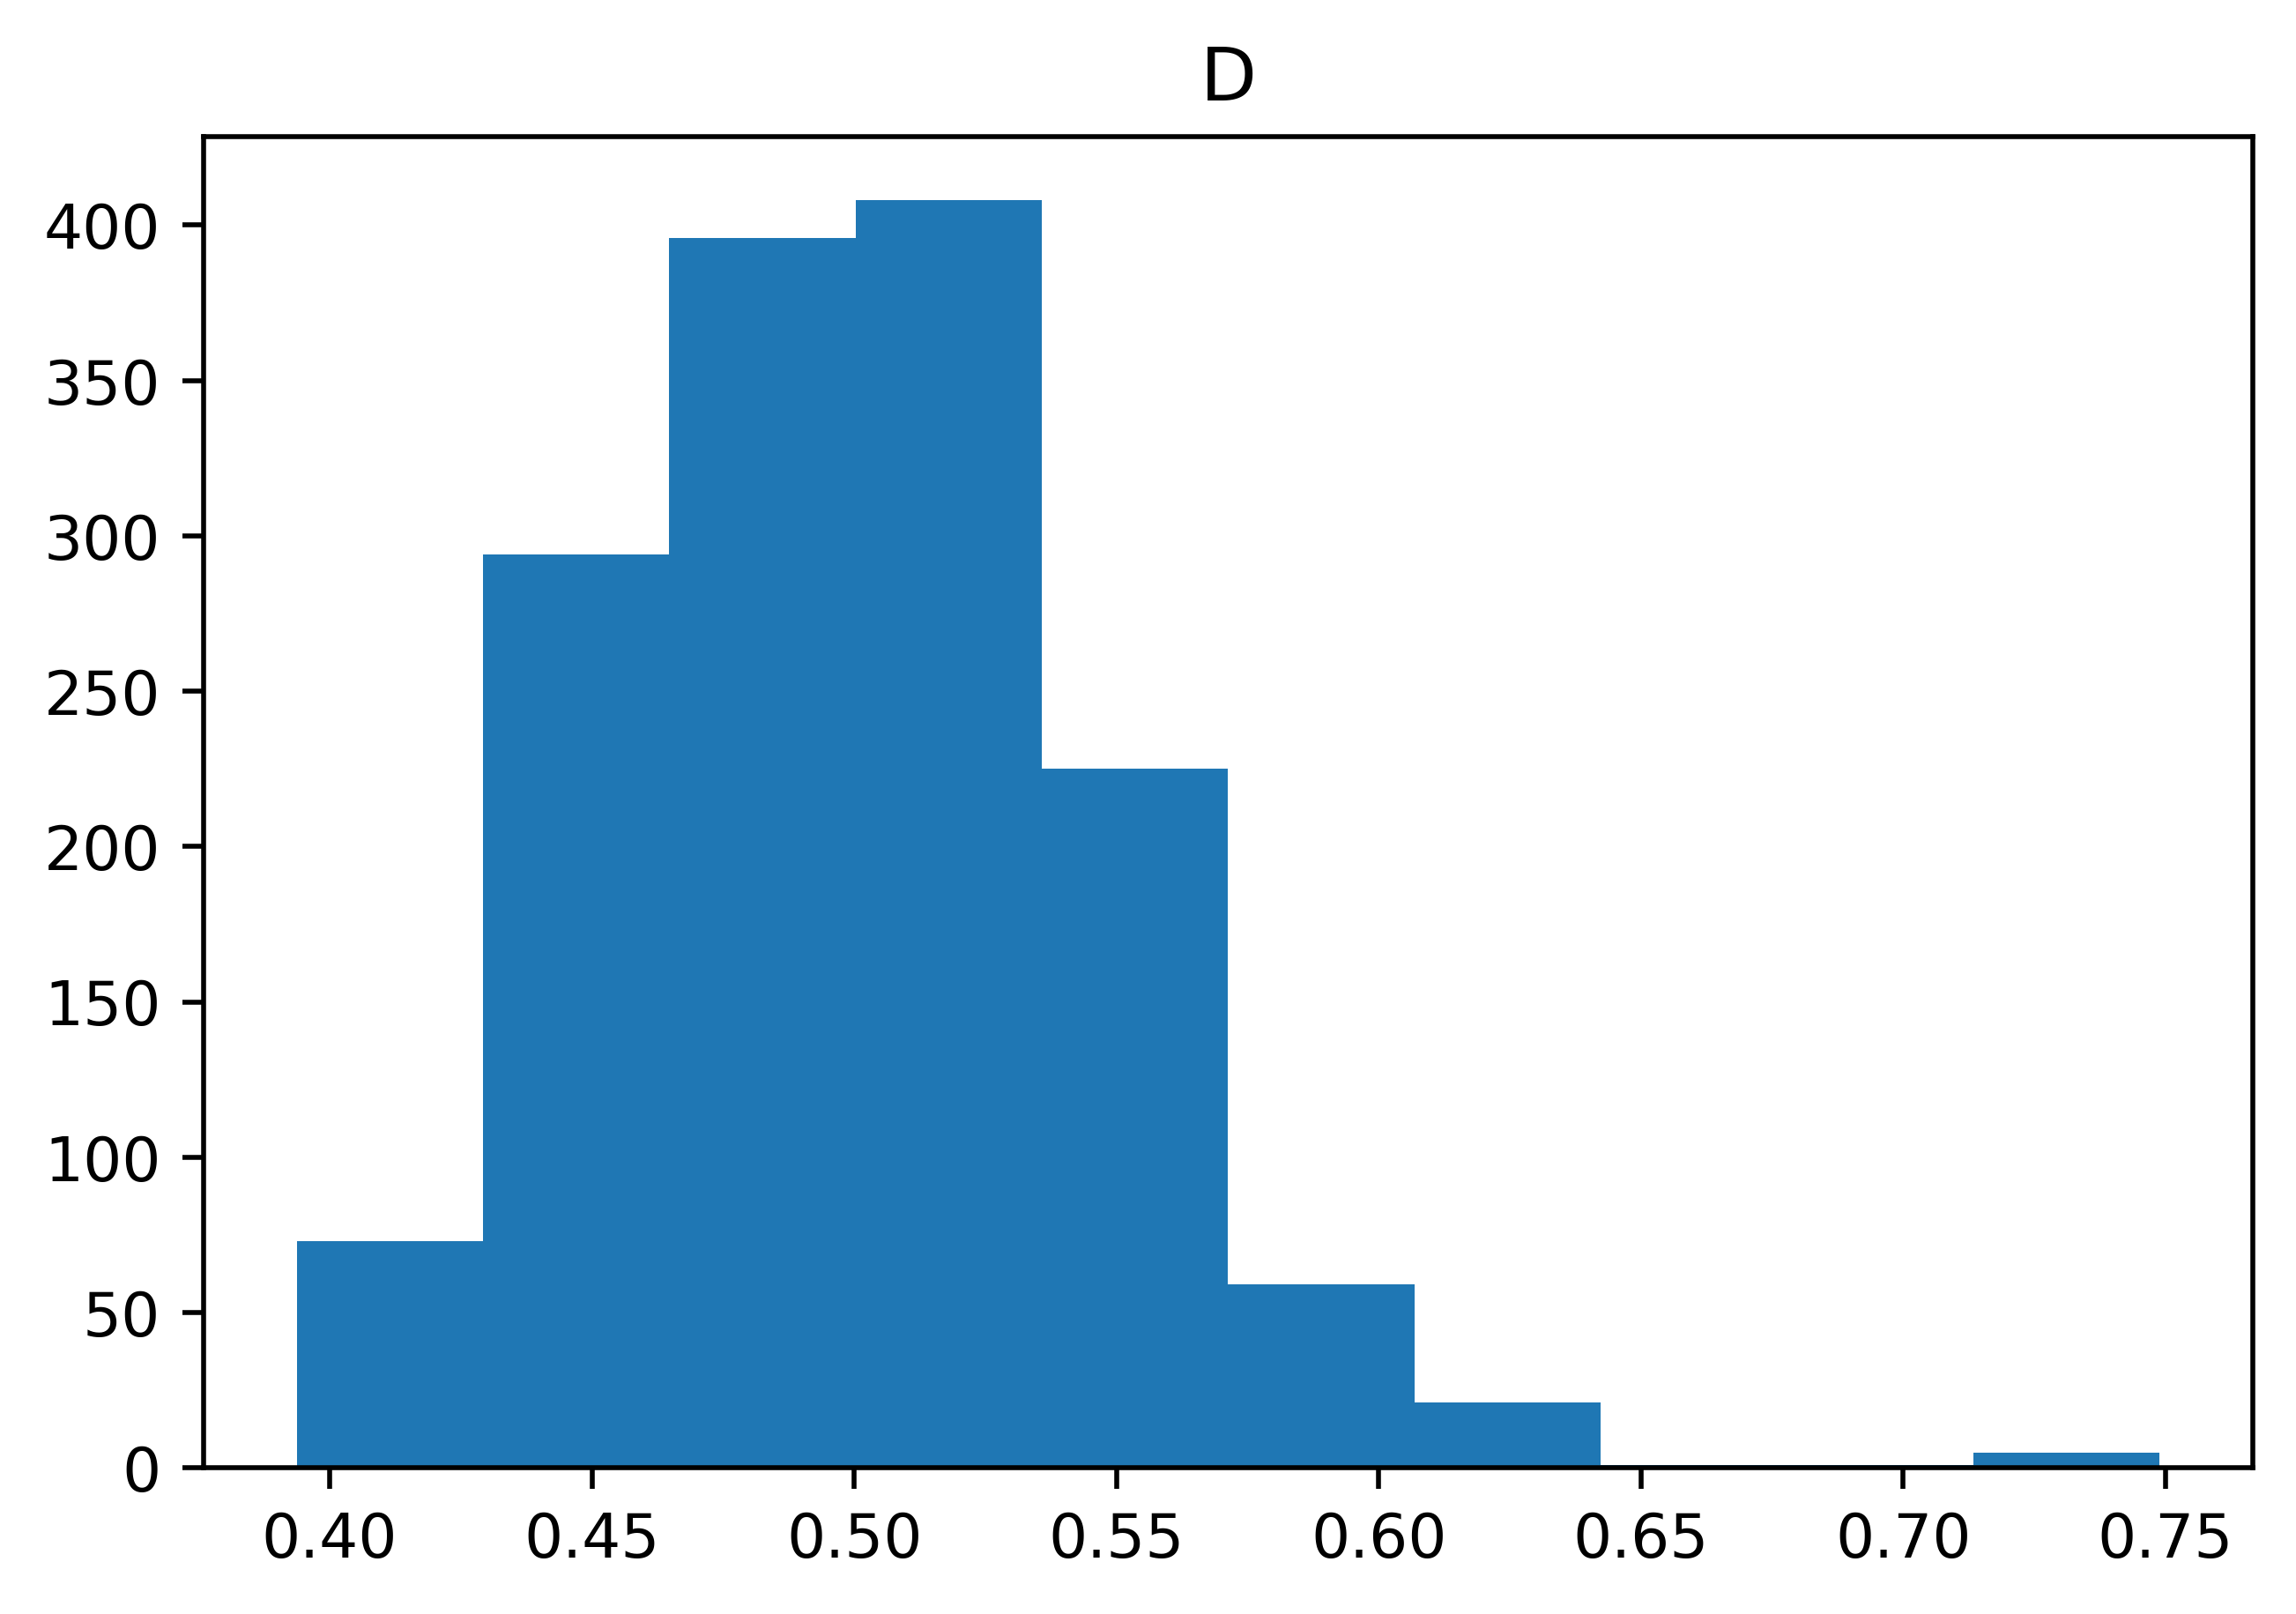

In [8]:
c13ab = 0.011
N = [(1-c13ab)**2,2*(1-c13ab)*c13ab,c13ab**2]
T = [0,0,1]
errs = []
T_founds = []
fluxImageG = np.zeros((len(tensorFilt[0]),len(tensorFilt[0][0])))
fluxImageD = np.zeros((len(tensorFilt[0]),len(tensorFilt[0][0])))
P_trues = []
P_preds = []

goodInd = []
for t in range(len(tensorFilt)):
    trel = tensorFilt[t][newImageBoundary > .5]
    if np.mean(trel) > 0.01:
        goodInd.append(t)

for r in range(len(tensorFilt[0])):
    for c in range(len(tensorFilt[0][0])):
        P = tensorFilt[:,r,c]
        if np.sum(P) > .5:
            g,D,T_found,err,P_pred = ISAFit(T,N,P,func,goodInd)
            errs.append(err)
            T_founds.append(T_found)
            P_trues.append(P)
            P_preds.append(P_pred)
        else:
            g,D = 0,0
        fluxImageG[r,c] = g
        fluxImageD[r,c] = D
        
plt.imshow(fluxImageG,cmap=colormap)
im = Image.fromarray(fluxImageG)
im.save(filename.replace(".txt","") + "_" + formula + "_g_" + '.tif')
plt.colorbar()
plt.title("g")
plt.figure()
plt.imshow(fluxImageD,cmap=colormap)
im = Image.fromarray(fluxImageD)
im.save(filename.replace(".txt","") + "_" + formula + "_D_" + '.tif')
plt.title("D")
plt.colorbar()
plt.figure()
plt.hist(errs)
plt.xlabel("SSE")
plt.ylabel("numPixels")
T_found = np.mean(T_founds,axis=0)/np.sum(np.mean(T_founds,axis=0))
print(T_found)

plt.figure()
x_ind = 0
x_lab = []
meanPred = np.mean(P_preds,axis=0)
stdPred = np.std(P_preds,axis=0)
meanTrue = np.mean(P_trues,axis=0)
stdTrue = np.std(P_trues,axis=0)
i = 0
for mP,sP,mT,sT in zip(meanPred,stdPred,meanTrue,stdTrue):
    plt.bar([x_ind,x_ind+1],[mP,mT],color=["red","black"],yerr = [sP,sT])
    x_lab.append([x_ind+.5,"M+" + str(i)])
    x_ind += 4
    i += 1
plt.xticks([x[0] for x in x_lab],[x[1] for x in x_lab],rotation=90)

plt.figure()

plt.hist(fluxImageG[fluxImageG > 0].flatten())
plt.title("g(t)")
plt.figure()
plt.hist(fluxImageD[fluxImageD > 0].flatten())
plt.title("D")
